<a href="https://colab.research.google.com/github/rozariot/Waste-Classification-Project/blob/main/WasteClassificationProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Data Loading Section

In [1]:
# import important libraries
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from math import floor
import os
import torchvision.models

use_cuda = True #enable usage of cuda GPU

In [2]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Loading the data 
#Toby's file directory paths (Note the MyDrive)
!unzip '/content/gdrive/MyDrive/APS360 Group Project/Data/zipped_data/test.zip' -d '/root/datasets'
!unzip '/content/gdrive/MyDrive/APS360 Group Project/Data/zipped_data/train.zip' -d '/root/datasets'
!unzip '/content/gdrive/MyDrive/APS360 Group Project/Data/zipped_data/val.zip' -d '/root/datasets'
!unzip '/content/gdrive/MyDrive/APS360 Group Project/Data/zipped_data/tiny.zip' -d '/root/datasets'



Archive:  /content/gdrive/MyDrive/APS360 Group Project/Data/zipped_data/test.zip
  inflating: /root/datasets/test/compost_other/O_2130.jpg  
  inflating: /root/datasets/test/compost_other/compost_tampons (18).jpg  
  inflating: /root/datasets/test/compost_other/O_5547.jpg  
  inflating: /root/datasets/test/compost_other/O_2511.jpg  
  inflating: /root/datasets/test/compost_other/O_2060.jpg  
  inflating: /root/datasets/test/garbage/more_wrap (3).jpg  
  inflating: /root/datasets/test/compost_other/O_2891.jpg  
  inflating: /root/datasets/test/compost_other/gbg_wrappers_papertowels (48).jpg  
  inflating: /root/datasets/test/compost_other/O_2674.jpg  
  inflating: /root/datasets/test/compost_other/O_2610.jpg  
  inflating: /root/datasets/test/garbage/gbgblackplastic (45).jpg  
  inflating: /root/datasets/test/compost_other/download (2).jpg  
  inflating: /root/datasets/test/compost_other/images (17).jpg  
  inflating: /root/datasets/test/garbage/gbg_wrappers_papertowels (83).jpg  
  inf

In [ ]:
# Loading the data
# Everyone else's file directory paths (Note the SharedDrive)
!unzip '/content/gdrive/Shareddrives/APS360 Group Project/Data/zipped_data/test.zip' -d '/root/datasets'
!unzip '/content/gdrive/Shareddrives/APS360 Group Project/Data/zipped_data/train.zip' -d '/root/datasets'
!unzip '/content/gdrive/Shareddrives/APS360 Group Project/Data/zipped_data/val.zip' -d '/root/datasets'
!unzip '/content/gdrive/Shareddrives/APS360 Group Project/Data/zipped_data/tiny.zip' -d '/root/datasets'


In [6]:
train_path = '/root/datasets/train'
val_path = '/root/datasets/val'
test_path = '/root/datasets/test'
tiny_path = '/root/datasets/tiny'

In [7]:
# Load the tensors
transformations = transforms.Compose([                                     
  transforms.Resize((224,224)),
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])
train_set = torchvision.datasets.ImageFolder(train_path, transform = transformations)
val_set = torchvision.datasets.ImageFolder(val_path, transform = transformations)
test_set = torchvision.datasets.ImageFolder(test_path, transform = transformations)
tiny_set = torchvision.datasets.ImageFolder(tiny_path, transform = transformations)

# Model and Training Functions and Classes

In [24]:
'''
Functions for training and getting accuracy
'''
def train(model, train_set, val_set, batch_size=64, num_epochs=1, learning_rate=0.001):
  iters = np.zeros(num_epochs)
  losses = np.zeros(num_epochs)
  train_acc = np.zeros(num_epochs)
  val_acc = np.zeros(num_epochs)

  # Fixed PyTorch random seed for reproducible result
  torch.manual_seed(1000)

  train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=1)#, shuffle=True)
  val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=1)#, shuffle=True)

  #use Cross entropy loss and Stochastic gradient descent
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

  # training
  n = 0 # the number of iterations
  for epoch in range(num_epochs):
      for i, data in enumerate(train_loader, 0):
          imgs, labels = data 
        
          #############################################
          #To Enable GPU Usage
          if use_cuda and torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()
          #############################################
          
            
          out = model(imgs)             # forward pass
          loss = criterion(out, labels) # compute the total loss
          loss.backward()               # backward pass (compute parameter updates)
          optimizer.step()              # make the updates for each parameter
          optimizer.zero_grad()         # a clean up step for PyTorch
          n += 1

      # save the current training information
      iters[epoch] = epoch 
      losses[epoch] = (float(loss)/batch_size)             # compute *average* loss
      train_acc[epoch] = get_accuracy(model, train_loader) # compute training accuracy 
      val_acc[epoch] = get_accuracy(model, val_loader)  # compute validation accuracy

          
          

      #printing out data
      print(("Epoch {}: Train accuracy: {}, Training Loss: {}, Validation Accuracy: {}").format(
                  epoch + 1,
                  train_acc[epoch],
                  losses[epoch],
                  val_acc[epoch]))

      # Save the current model (checkpoint) to a file
      model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
      torch.save(model.state_dict(), model_path)


  # plotting
  plt.title("Training Curve")
  plt.plot(iters, losses, label="Train")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.show()

  plt.title("Training Curve")
  plt.plot(iters, train_acc, label="Train")
  plt.plot(iters, val_acc, label="Validation")
  plt.xlabel("Iterations")
  plt.ylabel("Training Accuracy")
  plt.legend(loc='best')
  plt.show()

  print("Final Training Accuracy: {}".format(train_acc[-1]))
  print("Final Validation Accuracy: {}".format(val_acc[-1]))

# calculates accuracy
def get_accuracy(model, loader):
  correct = 0
  total = 0
  for imgs, labels in loader:    
      #############################################
      #To Enable GPU Usage
      if use_cuda and torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()
      #############################################        
      output = model(imgs)
      
      #select index with maximum prediction score
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(labels.view_as(pred)).sum().item()
      total += imgs.shape[0]
  return correct / total

# calculates accuracy of a label
# expects a batch size of 1
def get_accuracy_of_label(model, dataset, label):
  correct = 0
  total = 0
  loader = torch.utils.data.DataLoader(dataset, batch_size=1, num_workers=1)
  for imgs, labels in loader:
      #############################################
      #To Enable GPU Usage
      if use_cuda and torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()
      #############################################        
      output = model(imgs)
      
      #select index with maximum prediction score
      pred = output.max(1, keepdim=True)[1]
      if dataset.classes[labels] == label:
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
  return correct / total

def get_model_name(name, batch_size, learning_rate, epoch):
  """ Generate a name for the model consisting of all the hyperparameter values

  Args:
      config: Configuration object containing the hyperparameters
  Returns:
      path: A string with the hyperparameter name and value concatenated
  """
  path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                  batch_size,
                                                  learning_rate,
                                                  epoch)
  return path  

In [9]:
# Models for transfer learning
resnet18 = torchvision.models.resnet18(pretrained=True)
alexnet = torchvision.models.alexnet(pretrained=True)
googlenet = torchvision.models.googlenet(pretrained=True)
resnet152 = torchvision.models.resnet152(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


In [10]:
# function to transfer learning model features as tensors into folder
def save_features(model, model_name, dataset, directory, classes):
  '''
  model: the chosen transfer learning model
  directory: This is the directory where we want to save the tensors
  dataset: pass in tensor dataset
  classes: pass in array of list of classes
  '''
  loader = torch.utils.data.DataLoader(dataset, batch_size=1, num_workers=1)
  os.mkdir(directory)

  n = 0 # use this to track the number of the file
  for imgs, labels in loader:
    # extract features and save as tensors
    features = model(imgs)
    tensor_features = torch.from_numpy(features.detach().numpy())

    #create the class directory if it doesn't exist
    if (not os.path.exists(directory + '/' + classes[labels])):
      os.mkdir(directory + '/' + classes[labels])

    #save tensor file as a file
    #can be saved as a .pt file: https://pytorch.org/docs/stable/generated/torch.save.html
    torch.save(tensor_features.squeeze(0), directory + '/' + classes[labels] + '/' + model_name + '_' + str(n) + '.pt')

    n = n+1

In [11]:
class Waste_Classifier_ANN(nn.Module):
  def __init__(self, name="WasteNet", hidden_size=256*6*6):
    super(Waste_Classifier_ANN, self).__init__()
    self.name = name
    self.fc1 = nn.Linear(hidden_size, 50)
    self.fc2 = nn.Linear(50, 10)
    self.hidden_size = hidden_size

  def forward(self, x):
    x = x.view(-1, self.hidden_size) #flatten feature data
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [12]:
class Waste_Classifier_MLP(nn.Module):
  def __init__(self, name="WasteNet", hidden_size=256*6*6):
    super(Waste_Classifier_MLP, self).__init__()
    self.name = name
    self.fc1 = nn.Linear(hidden_size, 50)
    self.fc2 = nn.Linear(50, 30)
    self.fc3 = nn.Linear(30, 10)
    self.hidden_size = hidden_size

  def forward(self, x):
    x = x.view(-1, self.hidden_size) #flatten feature data
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

# Predictions and Testing --> AlexNet

In [13]:
# save Alex Net features first: Trying this model first
data_dir = '/root/datasets/AlexNet/'
train_dir = data_dir + 'train/'
val_dir = data_dir + 'val/'
test_dir = data_dir + 'test/'
tiny_dir = data_dir + 'tiny/'

os.mkdir(data_dir)
model = alexnet.features
save_features(model, "alexnet", tiny_set, tiny_dir, tiny_set.classes)
save_features(model, "alexnet", train_set, train_dir, train_set.classes)
save_features(model, "alexnet", val_set, val_dir, val_set.classes)
save_features(model, "alexnet", test_set, test_dir, test_set.classes)


In [14]:
feature_tiny_set = torchvision.datasets.DatasetFolder(tiny_dir, loader=torch.load, extensions=('.pt'))
feature_train_set = torchvision.datasets.DatasetFolder(train_dir, loader=torch.load, extensions=('.pt'))
feature_val_set = torchvision.datasets.DatasetFolder(val_dir, loader=torch.load, extensions=('.pt'))
feature_test_set = torchvision.datasets.DatasetFolder(test_dir, loader=torch.load, extensions=('.pt'))

Epoch 1: Train accuracy: 0.26666666666666666, Training Loss: 0.07695200443267822, Validation Accuracy: 0.26666666666666666
Epoch 2: Train accuracy: 0.43333333333333335, Training Loss: 0.07317289511362711, Validation Accuracy: 0.43333333333333335
Epoch 3: Train accuracy: 0.8, Training Loss: 0.06731022993723551, Validation Accuracy: 0.8
Epoch 4: Train accuracy: 0.9333333333333333, Training Loss: 0.060487449169158936, Validation Accuracy: 0.9333333333333333
Epoch 5: Train accuracy: 0.9333333333333333, Training Loss: 0.053065943717956546, Validation Accuracy: 0.9333333333333333
Epoch 6: Train accuracy: 0.9333333333333333, Training Loss: 0.045085410277048744, Validation Accuracy: 0.9333333333333333
Epoch 7: Train accuracy: 0.9333333333333333, Training Loss: 0.037086459000905354, Validation Accuracy: 0.9333333333333333
Epoch 8: Train accuracy: 0.9666666666666667, Training Loss: 0.029751022656758625, Validation Accuracy: 0.9666666666666667
Epoch 9: Train accuracy: 1.0, Training Loss: 0.023398

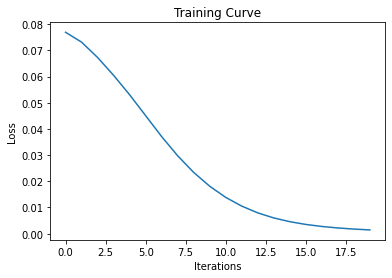

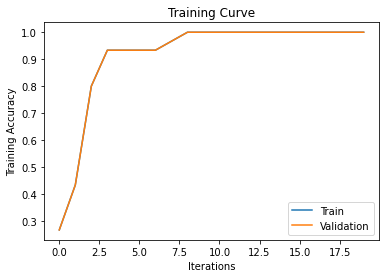

Final Training Accuracy: 1.0
Final Validation Accuracy: 1.0


In [ ]:
#Testing if I can overfit with Alex Net
alexNetClassify = Waste_Classifier_ANN(name="Waste_AlexNet")
if use_cuda and torch.cuda.is_available():
  alexNetClassify = alexNetClassify.cuda()
train(alexNetClassify, feature_tiny_set, feature_tiny_set, batch_size=30, num_epochs=20, learning_rate=0.002)

Epoch 1: Train accuracy: 0.10965848452508005, Training Loss: 0.018743792548775673, Validation Accuracy: 0.10897435897435898
Epoch 2: Train accuracy: 0.10939167556029883, Training Loss: 0.01851542294025421, Validation Accuracy: 0.10897435897435898
Epoch 3: Train accuracy: 0.10885805763073639, Training Loss: 0.018370766192674637, Validation Accuracy: 0.12393162393162394
Epoch 4: Train accuracy: 0.08911419423692636, Training Loss: 0.01829303428530693, Validation Accuracy: 0.09188034188034189
Epoch 5: Train accuracy: 0.13660618996798293, Training Loss: 0.018264027312397957, Validation Accuracy: 0.1282051282051282
Epoch 6: Train accuracy: 0.17849519743863393, Training Loss: 0.017810843884944916, Validation Accuracy: 0.1581196581196581
Epoch 7: Train accuracy: 0.14300960512273211, Training Loss: 0.017581460997462273, Validation Accuracy: 0.13675213675213677
Epoch 8: Train accuracy: 0.14701173959445038, Training Loss: 0.01744789630174637, Validation Accuracy: 0.13675213675213677
Epoch 9: Trai

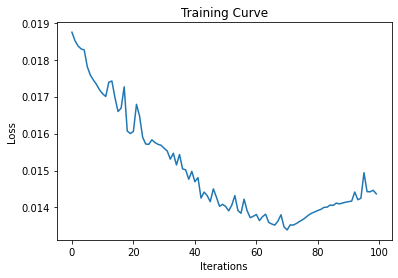

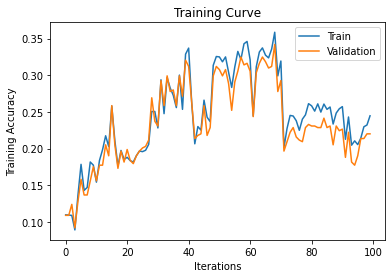

Final Training Accuracy: 0.24466382070437567
Final Validation Accuracy: 0.22008547008547008


In [ ]:
#Do Training with AlexNet
alexNetClassify = Waste_Classifier_ANN(name="Waste_AlexNet")
if use_cuda and torch.cuda.is_available():
  alexNetClassify = alexNetClassify.cuda()
train(alexNetClassify, feature_train_set, feature_val_set, batch_size=128, num_epochs=100, learning_rate=0.002)

Epoch 1: Train accuracy: 0.10378868729989328, Training Loss: 0.018556933850049973, Validation Accuracy: 0.0876068376068376
Epoch 2: Train accuracy: 0.09951974386339381, Training Loss: 0.01822330243885517, Validation Accuracy: 0.10042735042735043
Epoch 3: Train accuracy: 0.10512273212379936, Training Loss: 0.01803385652601719, Validation Accuracy: 0.10897435897435898
Epoch 4: Train accuracy: 0.26173959445037354, Training Loss: 0.017804361879825592, Validation Accuracy: 0.2564102564102564
Epoch 5: Train accuracy: 0.16088580576307365, Training Loss: 0.01766924187541008, Validation Accuracy: 0.14743589743589744
Epoch 6: Train accuracy: 0.326307363927428, Training Loss: 0.017674466595053673, Validation Accuracy: 0.31196581196581197
Epoch 7: Train accuracy: 0.3489861259338314, Training Loss: 0.017395256087183952, Validation Accuracy: 0.3418803418803419
Epoch 8: Train accuracy: 0.3143009605122732, Training Loss: 0.01877056434750557, Validation Accuracy: 0.30982905982905984
Epoch 9: Train accu

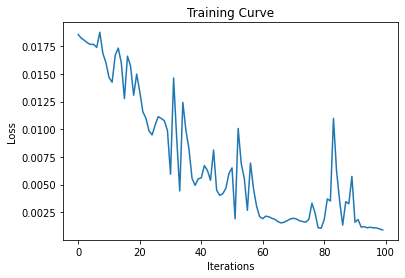

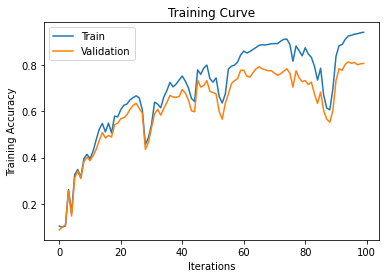

Final Training Accuracy: 0.942102454642476
Final Validation Accuracy: 0.8076923076923077


In [17]:
alexNetClassify = Waste_Classifier_MLP(name="Waste_AlexNetMLP")
if use_cuda and torch.cuda.is_available():
  alexNetClassify = alexNetClassify.cuda()
train(alexNetClassify, feature_train_set, feature_val_set, batch_size=128, num_epochs=100, learning_rate=0.002)

In [25]:
# See how best model performed within all sets of classes
# for the training set
for label in feature_train_set.classes:
  accuracy = get_accuracy_of_label(alexNetClassify, feature_train_set, label)
  print("Accuracy of label " + str(label) + " is " + str(accuracy))

Accuracy of label compost_food is 1.0
Accuracy of label compost_other is 0.9314516129032258
Accuracy of label garbage is 0.8936170212765957
Accuracy of label recy_bags is 0.9275766016713092
Accuracy of label recy_bottles is 0.9434889434889435
Accuracy of label recy_cans is 0.9738219895287958
Accuracy of label recy_cups is 0.9610705596107056
Accuracy of label recy_other_containers is 0.85
Accuracy of label recy_paper is 0.9898734177215189
Accuracy of label recy_styrofoam is 0.9405940594059405


In [26]:
# see how best model performed for all sets of classes within 
# the validation set
for label in feature_val_set.classes:
  accuracy = get_accuracy_of_label(alexNetClassify, feature_val_set, label)
  print("Accuracy of label " + str(label) + " is " + str(accuracy))

Accuracy of label compost_food is 0.8333333333333334
Accuracy of label compost_other is 0.7741935483870968
Accuracy of label garbage is 0.6595744680851063
Accuracy of label recy_bags is 0.9111111111111111
Accuracy of label recy_bottles is 0.8235294117647058
Accuracy of label recy_cans is 0.7708333333333334
Accuracy of label recy_cups is 0.8627450980392157
Accuracy of label recy_other_containers is 0.723404255319149
Accuracy of label recy_paper is 0.8979591836734694
Accuracy of label recy_styrofoam is 0.803921568627451


# Predictions and Testing --> ResNet18

In [ ]:
# save Alex Net features first: Trying this model first
data_dir = '/root/datasets/ResNet/'
train_dir = data_dir + 'train/'
val_dir = data_dir + 'val/'
test_dir = data_dir + 'test/'
tiny_dir = data_dir + 'tiny/'

os.mkdir(data_dir)
model = nn.Sequential(*list(resnet18.children())[:-1])
save_features(model, "ResNet", tiny_set, tiny_dir, tiny_set.classes)
save_features(model, "ResNet", train_set, train_dir, train_set.classes)
save_features(model, "ResNet", val_set, val_dir, val_set.classes)
save_features(model, "ResNet", test_set, test_dir, test_set.classes)
feature_tiny_set = torchvision.datasets.DatasetFolder(tiny_dir, loader=torch.load, extensions=('.pt'))
feature_train_set = torchvision.datasets.DatasetFolder(train_dir, loader=torch.load, extensions=('.pt'))
feature_val_set = torchvision.datasets.DatasetFolder(val_dir, loader=torch.load, extensions=('.pt'))
feature_test_set = torchvision.datasets.DatasetFolder(test_dir, loader=torch.load, extensions=('.pt'))

In [ ]:
#Testing if I can overfit with ResNet
resNetClassify = Waste_Classifier_MLP(name="Waste_ResNet", hidden_size=512*1*1)
if use_cuda and torch.cuda.is_available():
  resNetClassify = resNetClassify.cuda()
train(resNetClassify, feature_tiny_set, feature_tiny_set, batch_size=15, num_epochs=200, learning_rate=0.001)

Epoch 1: Train accuracy: 0.13333333333333333, Training Loss: 0.15138986905415852, Validation Accuracy: 0.13333333333333333
Epoch 2: Train accuracy: 0.06666666666666667, Training Loss: 0.1514359951019287, Validation Accuracy: 0.06666666666666667
Epoch 3: Train accuracy: 0.06666666666666667, Training Loss: 0.15147871971130372, Validation Accuracy: 0.06666666666666667
Epoch 4: Train accuracy: 0.06666666666666667, Training Loss: 0.15151124000549315, Validation Accuracy: 0.06666666666666667
Epoch 5: Train accuracy: 0.06666666666666667, Training Loss: 0.15153400103251138, Validation Accuracy: 0.06666666666666667
Epoch 6: Train accuracy: 0.03333333333333333, Training Loss: 0.1515536626180013, Validation Accuracy: 0.03333333333333333
Epoch 7: Train accuracy: 0.1, Training Loss: 0.15157128969828287, Validation Accuracy: 0.1
Epoch 8: Train accuracy: 0.1, Training Loss: 0.15158524513244628, Validation Accuracy: 0.1
Epoch 9: Train accuracy: 0.1, Training Loss: 0.1515952428181966, Validation Accura

Exception ignored in: <function _releaseLock at 0x7fd97d0088c0>
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 221, in _releaseLock
    def _releaseLock():
KeyboardInterrupt


Epoch 83: Train accuracy: 0.1, Training Loss: 0.15191100438435873, Validation Accuracy: 0.1
Epoch 84: Train accuracy: 0.1, Training Loss: 0.1519147237141927, Validation Accuracy: 0.1
Epoch 85: Train accuracy: 0.1, Training Loss: 0.15191756884257, Validation Accuracy: 0.1
Epoch 86: Train accuracy: 0.1, Training Loss: 0.1519213358561198, Validation Accuracy: 0.1
Epoch 87: Train accuracy: 0.1, Training Loss: 0.1519279638926188, Validation Accuracy: 0.1
Epoch 88: Train accuracy: 0.1, Training Loss: 0.1519339720408122, Validation Accuracy: 0.1
Epoch 89: Train accuracy: 0.1, Training Loss: 0.15193939208984375, Validation Accuracy: 0.1
Epoch 90: Train accuracy: 0.1, Training Loss: 0.1519450028737386, Validation Accuracy: 0.1


KeyboardInterrupt: ignored

# Baseline Model: Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
forest = RandomForestClassifier(n_estimators=200, bootstrap=True, max_features='sqrt')
forest.fit(train_data, train_labels)
predictions = forest.predict(val_data)

print(accuracy_score(predictions, val_labels))
